# Battery Heater Thresholds

In [1]:
from glob import glob
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import parse

## File Input

Read all datasets found in the `SatelliteData` directory via Pandas. `Parse.readFile()` performs filtering and conversion as well: it changes the timestamps from milliseconds since epoch to Datetime objects, and rejects temperatures outside of $-50^\circ \text{C} < T < 50^\circ \text{C}$.

In [2]:
filepaths = glob('./SatelliteData/satellite*.csv')
dfs  = {} # Dictionary to hold dataframes
for path in filepaths:
    sat = path[25:-4] # pull out the HWID
    dfs[sat] = parse.readFile(path)

## Time Series View

Since we want the temperatures to stay above $0^\circ \text{C}$, we can check how effective our control schemes are by viewing the time series of each satellite's battery pack temperatures. In each graph, we can see the changing $\beta$ angle of the orbital plane (large scale variations), and the smaller thermal cycles from heaters turning on-and-off and satellites entering and exiting eclipse (local maxs and mins).

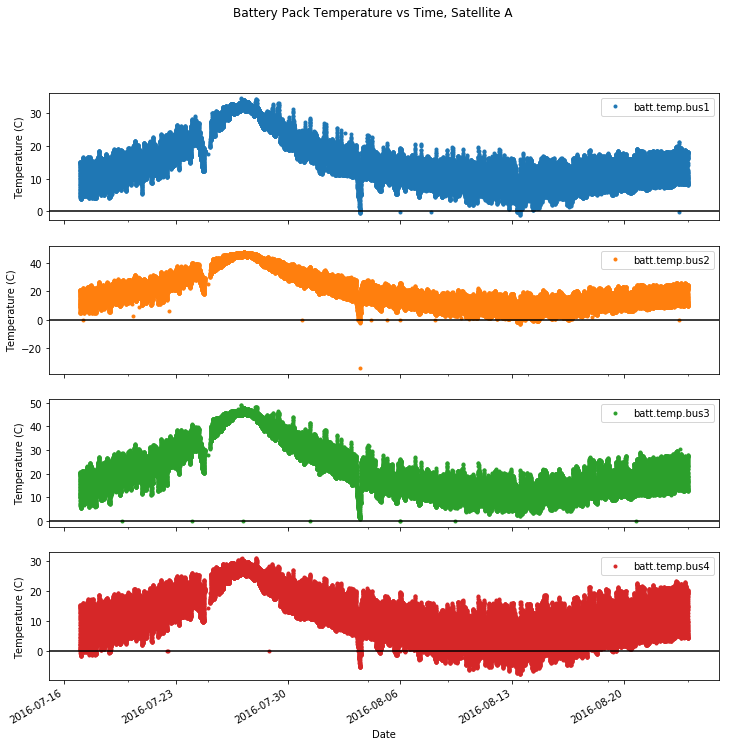

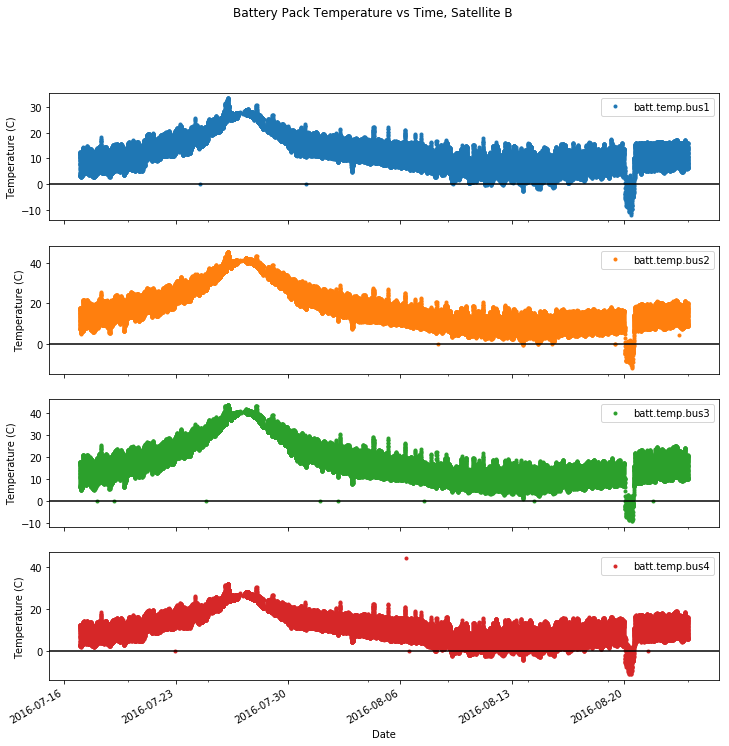

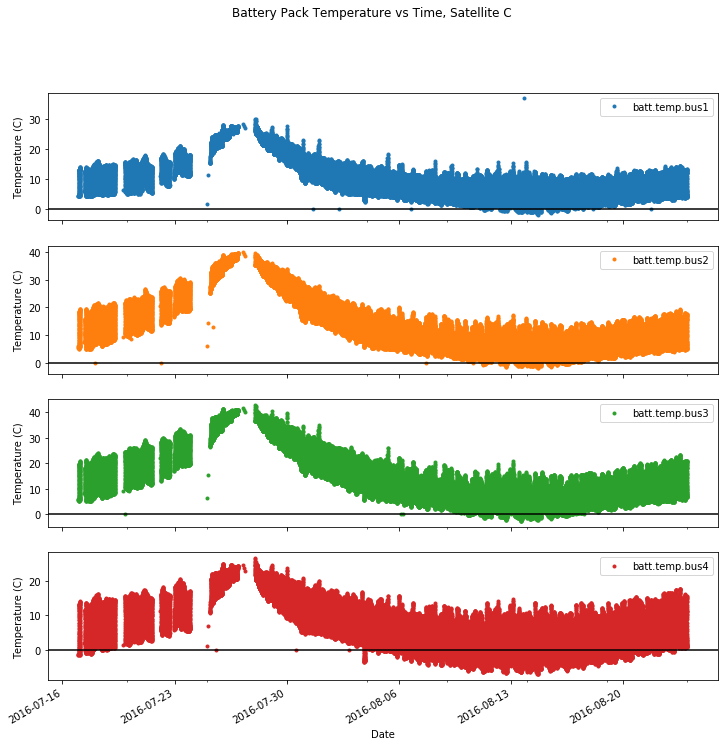

In [3]:
for sat in sorted(dfs.keys()):
    parse.plotTime(dfs[sat], sat)
plt.show()

A single thermal cycle can be seen below. Note the inflection points when each pack crosses $5^\circ \text{C}$, a result of the pack heater turning on, and similarly for $T=10^\circ \text{C}$ for the heater off event. Additionally, the temperature of pack 4 can be observed dropping below $0^\circ \text{C}$.

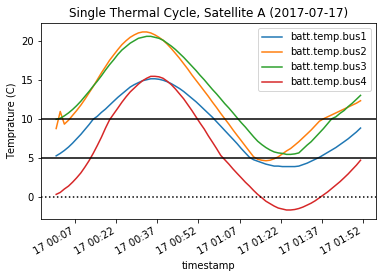

In [4]:
ax = dfs['A'].head(75).plot(x='timestamp', 
                            y=['batt.temp.bus1', 'batt.temp.bus2', 'batt.temp.bus3', 'batt.temp.bus4'], 
                            title='Single Thermal Cycle, Satellite A (2017-07-17)')
ax.axhline(y=5, color='k')
ax.axhline(y=10,color='k')
ax.axhline(y=0, color='k', linestyle=':')
ax.set_ylabel('Temprature (C)');

## Temperature Distribution

A better way to quantitatively analyze how well the temperature stays in our bounds is by looking at the temperature distribution. #TODO: note results 

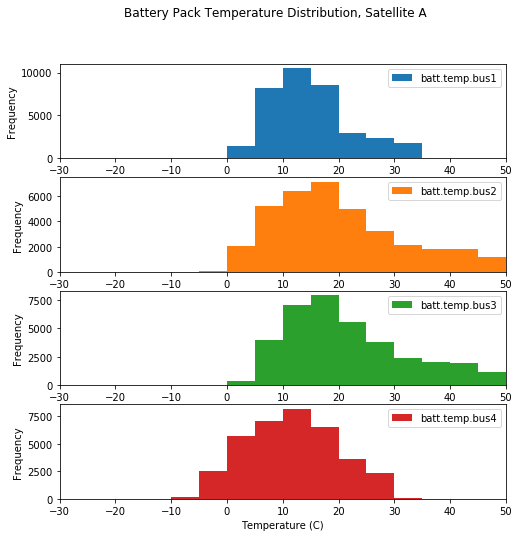

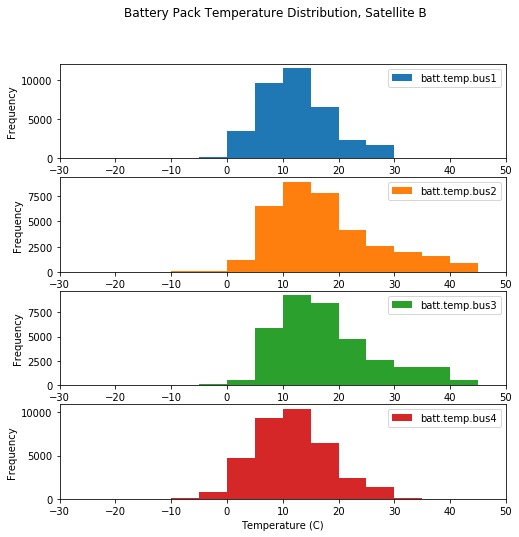

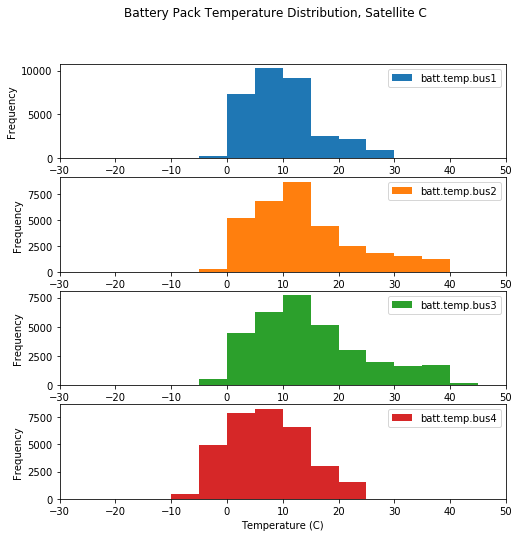

In [5]:
for sat in sorted(dfs.keys()):
    parse.plotDist(dfs[sat], sat)
plt.show()

## Filtering by Threshold

In order to examine how effective the new heating thresholds are, we can partition the data into an active experiment set (with $T_{\text{on}}/T_{\text{off}} = 11/16^\circ \text{C}$) and a set where the experiment is inactive ($T_{\text{on}}/T_{\text{off}} = 5/10^\circ \text{C}$).

In [6]:
activeA = dfs['A'][dfs['A']['timestamp'] >= datetime.fromisoformat('2016-07-20T23:09:46')]
inactiveA = dfs['A'][dfs['A']['timestamp'] < datetime.fromisoformat('2016-07-20T23:09:46')]

activeB = dfs['B'][dfs['B']['timestamp'] >= datetime.fromisoformat('2016-07-21T02:34:52')]
inactiveB = dfs['B'][dfs['B']['timestamp'] < datetime.fromisoformat('2016-07-21T02:34:52')]

One interesting thing to note is that both satellites reboot shortly after the new thresholds become active. Presumably, this is happening during a pass with a ground station, so the thresholds become active within minutes.

In [7]:
activeA.head()

,timestamp,batt.temp.bus1,batt.temp.bus2,batt.temp.bus3,batt.temp.bus4,sc.bootcount
3877,2016-07-20 23:10:38.054,10.4375,13.50,15.4375,5.375,NaN
3878,2016-07-20 23:10:42.540,NaN,NaN,NaN,NaN,228.0
3879,2016-07-20 23:11:23.967,NaN,NaN,NaN,NaN,228.0
3880,2016-07-20 23:12:07.113,10.1875,12.75,14.7500,4.875,NaN
3881,2016-07-20 23:12:07.297,10.1875,12.75,14.7500,4.875,NaN


In [8]:
activeB.head(8)

,timestamp,batt.temp.bus1,batt.temp.bus2,batt.temp.bus3,batt.temp.bus4,sc.bootcount
4099,2016-07-21 02:36:00.926,NaN,NaN,NaN,NaN,16.0
4100,2016-07-21 02:36:07.097,10.0625,16.2500,15.5625,9.2500,NaN
4101,2016-07-21 02:36:58.184,NaN,NaN,NaN,NaN,16.0
4102,2016-07-21 02:37:15.368,9.9375,16.0000,15.3125,9.1250,NaN
4103,2016-07-21 02:37:37.085,9.8750,15.9375,15.2500,9.0625,NaN
4104,2016-07-21 02:37:49.522,NaN,NaN,NaN,NaN,16.0
4105,2016-07-21 02:39:08.058,9.8125,15.6875,15.0000,9.0000,NaN
4106,2016-07-21 02:40:37.121,9.7500,15.5625,14.8750,8.9375,NaN


The datasets are combined together, then we can again look at the time series and distribution of the temperatures.

In [9]:
active = pd.concat([activeA, activeB], keys=['A', 'B'])
inactive = pd.concat([dfs['C'], inactiveA, inactiveB], keys=['C', 'A', 'B'])

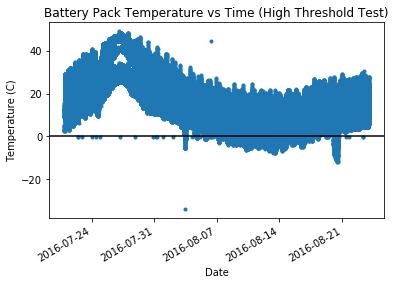

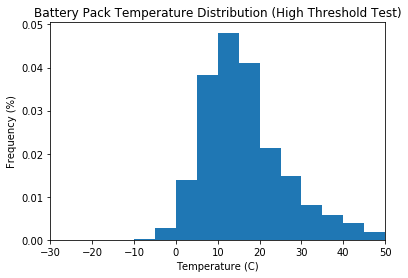

In [10]:
active_reduced = parse.plotReduce(active,'High Threshold Test')
plt.show()

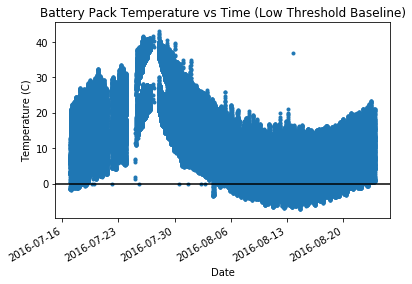

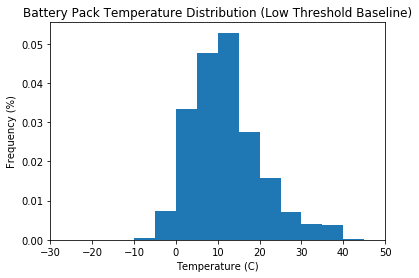

In [11]:
inactive_reduced = parse.plotReduce(inactive,'Low Threshold Baseline')
plt.show()

The histograms show that higher threshold did indeed have less samples below $0^\circ \text{C}$. Let's make a numerical comparision.

In [12]:
count_act_below   = len(active_reduced[active_reduced['batt.temp'] <= 0])
count_act_total   = len(active_reduced)
act_percent = 100 * count_act_below / float(count_act_total)
print('Count Active <= 0C: \t%d(/%d, %.2f%%)' % (count_act_below, count_act_total, act_percent))

count_inact_below   = len(inactive_reduced[inactive_reduced['batt.temp'] <= 0])
count_inact_total   = len(inactive_reduced)
inact_percent = 100 * count_inact_below / float(count_inact_total)
print('Count Inactive <= 0C: \t%d(/%d, %.2f%%)' % (count_inact_below, count_inact_total, inact_percent))

Count Active <= 0C: 	4001(/260228, 1.54%)
Count Inactive <= 0C: 	6387(/164341, 3.89%)


This reduction works out to be a substantial decrease: an over 60% reduction in samples below the desired temperature of $0^\circ \text{C}$.

In [13]:
decrease = 100 * (act_percent - inact_percent) / inact_percent
print('Effect of threshold change: %.2f%%' % decrease)

Effect of threshold change: -60.44%


Unfortunately, the changed thresholds don't completely prevent the satellite from reading temperatures below $0^\circ \text{C}$. To determine if the result is acceptable, a few figures could be calculated: the total amount of time spent below $0^\circ \text{C}$ would reveal how the long-term degradation of the battery is progressing, and the average length of each excursion below freezing could show the short-term impact (how long the sat operates in reduced power). In light of other considerations the higher thresholds, even though they don't totally prevent low temperatures, might be acceptable.

## Effects of Beta Angle

Looking at the whole time series for any set of data, a full period of $\beta$ angles can be observed. When $\beta$ is maximized (around 2016-07-29) the time spent in sunlight is maximized, resulting in higher temperatures across the battery packs. When $\beta = 0^\circ$ (around 2016-08-13) the time spent in eclipse is maximize, which causes lower temperatures across the battery packs. Additionally, the heaters are forced to be much more active, both in frequency and duration of "on" periods. Since the satellite doesn't receive as much sunlight it is both cooler and harder to warm up without the additional thermal input of the sun.

## Other Considerations
Though the higher thresholds were more effective in maintaining the battery temperature (only $1.54\%$ samples with $T<=0^\circ\text{C}$), there are several possible drawbacks to this approach: #TODO: make sure % is right

 * Temperature of other components:
 
    - Similar to the batteries' operating temperatures, the other components of the Doves have ideal temperatures. In particular, the telescopic lens that allows the Dove to image the Earth has an ideal temperature where it is in focus. Heating the batteries during an imaging operation might cause the lens to go out of focus, to the detriment of the final product. Other issues might arise through thermal interference with the on-board computers, radios, reaction wheels, and other components.
 
 * Wear and tear on patch heaters:
     - The patch heaters have a certain lifespan that is primarily impacted by total operating time and total power cycles. Running them more often decreases the availible lifespan, increasing the chance of heater failure and performace degradation. #TODO: maybe make a function to count cycles over a day

 * Potential differences:
     - Each heater performs slightly differently. While the higher thresholds might succeed on one battery pack, they might be ineffective on another, even on the same satellite. Furthermore, different satellites have even more different performance characteristics, and different orbital planes might exhibit even more differences due to $\beta$ angle variations. Fleetwide testing could either ensure that the higher thresholds (if accepted) result in a acceptable percentage of success (time below $0^\circ \text{C}$), or the thresholds could be set for each satellite individually. A fleet-wide process could be automated to start each satellite at a particular set of thresholds, then evaluate the temperature data to see if the thresholds need to be raised or lowered (a temperature controller controller, if you will).
 

## Scratch Work